In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_img = pd.read_csv('dataset/train/images.csv',header = None)
train_label = pd.read_csv('dataset/train/labels.csv',header = None)
val_img = pd.read_csv('dataset/validation/images.csv',header = None)
val_label = pd.read_csv('dataset/validation/labels.csv',header = None)

In [3]:
print(train_img.shape)
print(train_label.shape)
print(val_label.shape)
print(val_img.shape)

(3200, 8192)
(3200, 4)
(800, 4)
(800, 8192)


In [4]:
train_img.head()

,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,...,0.639216,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,...,0.639216,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412


In [5]:
#dimensions of the image is (64,128,1)
x_train = train_img.values.reshape(3200,64,128,1)
x_val = val_img.values.reshape(800,64,128,1)
y_train = train_label.values
y_val = val_label.values

In [6]:
print(x_train.shape,x_val.shape)
print(y_train.shape,y_val.shape)

(3200, 64, 128, 1) (800, 64, 128, 1)
(3200, 4) (800, 4)


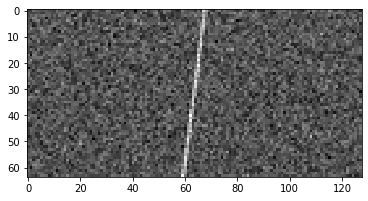

In [7]:
#2-D Spectrograms
plt.imshow(np.squeeze(x_train[np.random.randint(0,x_train.shape[0])]),cmap = 'binary')

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen_train = ImageDataGenerator(horizontal_flip = True)
datagen_val = ImageDataGenerator(horizontal_flip = True)
datagen_train.fit(x_train)
datagen_val.fit(x_val)

In [9]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
# Initialising the CNN
model = Sequential()

# 1st Convolution layer
model.add(Conv2D(32,(5,5), padding='same', input_shape=(64, 128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(64,(7,7), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#3rd Convolution Layer
model.add(Conv2D(32,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

#Fully connected layer 2
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(4, activation='softmax'))
initial_learning_rate = 0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5,
    decay_rate=0.96,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 128, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 64, 128, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 64)        100416    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 64, 64)        2

In [10]:
batch_size = 64
model.fit(
    datagen_train.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
    steps_per_epoch=len(x_train)//batch_size,
    validation_data = datagen_val.flow(x_val, y_val, batch_size=batch_size, shuffle=True),
    validation_steps = len(x_val)//batch_size,
    epochs=50,
    #callbacks=callbacks
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 12 steps
Epoch 1/50
50/50 [==============================] - 110s 2s/step - loss: 0.5912 - accuracy: 0.6837 - val_loss: 9.3930 - val_accuracy: 0.2461
Epoch 2/50
50/50 [==============================] - 108s 2s/step - loss: 0.4002 - accuracy: 0.7419 - val_loss: 3.3313 - val_accuracy: 0.2526
Epoch 3/50
50/50 [==============================] - 106s 2s/step - loss: 0.3742 - accuracy: 0.7394 - val_loss: 3.7283 - val_accuracy: 0.2526
Epoch 4/50
50/50 [==============================] - 79s 2s/step - loss: 0.3656 - accuracy: 0.7491 - val_loss: 3.9987 - val_accuracy: 0.2526
Epoch 5/50
50/50 [==============================] - 79s 2s/step - loss: 0.3662 - accuracy: 0.7453 - val_loss: 3.9031 - val_accuracy: 0.2513
Epoch 6/50
50/50 [==============================] - 81s 2s/step - loss: 0.3614 - accuracy: 0.7416 - val_loss: 3.3228 - val_accuracy: 0.2617
Epoch 7/50
50/50 [==============================] - 88s 2s/step -

In [11]:
model.evaluate(x_val, y_val)

800/800 [==============================] - 4s 4ms/sample - loss: 0.3646 - accuracy: 0.7487


[0.3645500365399494, 0.74875]